In [227]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy import signal
from scipy.signal import butter, filtfilt, hilbert

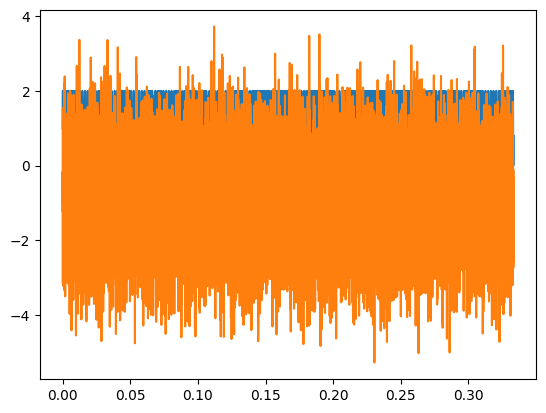

SNR 1.75 dB


In [228]:
import numpy as np
import random
import matplotlib.pyplot as plt


noise_mult = 1
signal_mult = 1
sampling_rate = 44100
baud_rate = 300
freq_carrier = 1000
freq_div = 500
n_data = 100
samples_per_bit =  sampling_rate//baud_rate

# tones representing bits, dummy data (0,1)
bits_source = np.random.randint(0, 2, n_data)
bits_in_tones = [(freq_carrier-freq_div, freq_carrier+freq_div)[a] for a in bits_source]
#random.shuffle(bits_in_tones)
bit_arr = np.array(bits_in_tones)

symbols_freqs = np.repeat(bit_arr, samples_per_bit)

t = np.arange(0, len(symbols_freqs) / sampling_rate, 1.0 / sampling_rate)

np.random.seed(1471) # LEGACY
noise = np.random.randn(t.shape[0]) * noise_mult

signal = np.sin(2.0 * np.pi * symbols_freqs * (t))

# New lines here demonstrating continuous phase FSK (CPFSK)
delta_phi = symbols_freqs * np.pi / (sampling_rate / 2.0)
phi = np.cumsum(delta_phi)
signal2 = np.sin(phi) * signal_mult
signal2 = signal2 + noise

plt.plot(t, signal+1.0)
plt.plot(t, signal2-1.0)
plt.show()
snr = 10 * np.log10(np.mean(np.square(signal2)) / np.mean(np.square(noise)))
print(f"SNR {snr:.2f} dB")
# phi

In [229]:
# Filter parameters
cutoff_freq = 1500  # Cutoff frequency in Hz
fs = sampling_rate  # Sampling rate in Hz
order = 8  # Filter order

# Design the high-pass filter (change btype to 'highpass')
nyq = 0.5 * fs
normal_cutoff = cutoff_freq / nyq
d, c = butter(order, normal_cutoff, btype='lowpass')  # <-- modify here

b, a = butter(order, normal_cutoff, btype='highpass')  # <-- modify here

# Apply the filter
filtered_data1 = filtfilt(d, c, signal2)
filtered_data = filtfilt(b, a, filtered_data1)

envelope = abs(hilbert(filtered_data)) * 3
bits_recovered = envelope > signal_mult/2.7
bits_recovered = bits_recovered[samples_per_bit//2:len(bits_recovered):samples_per_bit].astype(int)

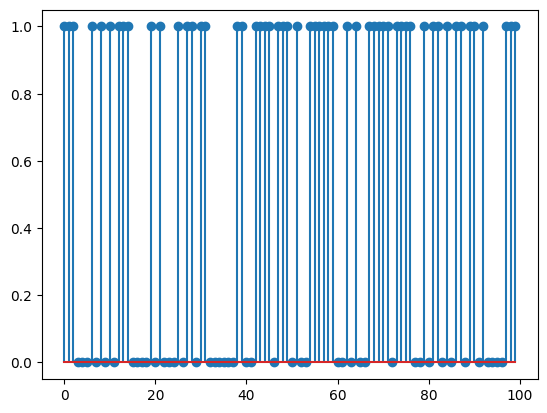

In [230]:
plt.stem(bits_recovered)
plt.show()

In [231]:
print(f"{float(sum(bits_recovered == np.array(bits_source)) / len(bits_source) * 100)}%")


100.0%


In [232]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.fft import fftshift
# from scipy.signal import stft, istft, spectrogram, ShortTimeFFT

# fs, N = sampling_rate, len(filtered_data)  # 200 Hz sampling rate for 5 s signal
# t_z = np.arange(N) / fs  # time indexes for signal
# z = np.exp(2j*np.pi*70 * (t_z - 0.2*t_z**2))  # complex-valued chirp

# nperseg, noverlap = 50, 40
# win = ('gaussian', 1e-2 * fs)  # Gaussian with 0.01 s standard dev.

# # Legacy STFT:
# f0_u, t0, Sz0_u = stft(z, fs, win, nperseg, noverlap,
#                        return_onesided=False, scaling='spectrum')
# f0, Sz0 = fftshift(f0_u), fftshift(Sz0_u, axes=0)

# # New STFT:
# SFT = ShortTimeFFT.from_window(win, fs, nperseg, noverlap, fft_mode='centered',
#                                scale_to='magnitude', phase_shift=None)
# Sz1 = SFT.stft(filtered_data1)

# # Plot results:
# fig1, axx = plt.subplots(1, 1, sharex='all', sharey='all',
#                          figsize=(6., 5.))  # enlarge figure a bit
# t_lo, t_hi, f_lo, f_hi = SFT.extent(N, center_bins=True)
# axx.set_title(r"ShortTimeFFT produces $%d\times%d$ points" % Sz1.T.shape)
# axx.set_xlabel(rf"Time $t$ in seconds ($\Delta t= {SFT.delta_t:g}\,$s)")

# # Calculate extent of plot with centered bins since
# # imshow does not interpolate by default:
# dt2 = (nperseg-noverlap) / fs / 2  # equals SFT.delta_t / 2
# df2 = fs / nperseg / 2  # equals SFT.delta_f / 2
# extent0 = (-dt2, t0[-1] + dt2, f0[0] - df2, f0[-1] - df2)
# extent1 = SFT.extent(N, center_bins=True)

# kw = dict(origin='lower', aspect='auto', cmap='viridis')
# #im1a = axx[0].imshow(abs(Sz0), extent=extent0, **kw)
# im1b = axx.imshow(abs(Sz1), extent=extent1, **kw)
# fig1.colorbar(im1b, ax=axx, label="Magnitude $|S_z(t, f)|$")
# _ = fig1.supylabel(r"Frequency $f$ in Hertz ($\Delta f = %g\,$Hz)" %
#                    SFT.delta_f, x=0.08, y=0.5, fontsize='medium')
# plt.show()